In [18]:
# Import the libraries/files we want to run
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
import importlib
# local files (stuff we wrote)
import DataProcessing
import ProjectMap
import BaseModel
import DualInputModel
import Analysis
from scripts.DataProcessing import adaptive_segmentation

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
#This allows changes to be reflected whenever we make them
importlib.reload(DataProcessing)
importlib.reload(BaseModel)
importlib.reload(DualInputModel)

GPU is available


<module 'DualInputModel' from '/mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/scripts/DualInputModel.py'>

In [2]:
# Get the directory layout of the project
PROJECT_MAP= ProjectMap.ProjectMap()
print(PROJECT_MAP)

Root: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project
Scripts: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/scripts
Data: /mnt/c/Users/codyr/Code/AI-570/Final_Project/AI570_DeepLearning_Project/data


In [3]:
# This gives us a reusable function to load data
# Odds are this is not how we will actually handle the data, it's just easy to do this for the base model
#Added in logic to bring in Plant ID dataset from - https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets?resource=download

training_data, val_data, testing_data, classes = DataProcessing.loadAllDatasets(PROJECT_MAP.dataDirectory)

Found 23972 files belonging to 30 classes.


I0000 00:00:1753059793.241046   79332 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.


In [4]:
# Working with the base model, not meant to be good, just a starting point
# Will probably be removed later
base_model= BaseModel.BaseModel()

layers = [
    keras.layers.Input(shape=(128, 128, 3)),
    keras.layers.Rescaling(1./255),  # normalize pixel values
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(len(classes), activation="softmax")
]

base_model.buildModel(layers)
base_model.compileModel()
#training_results= base_model.trainModel(training_data, val_data=val_data) 
#base_model.testModel(testing_data)

Model built
Model compiled


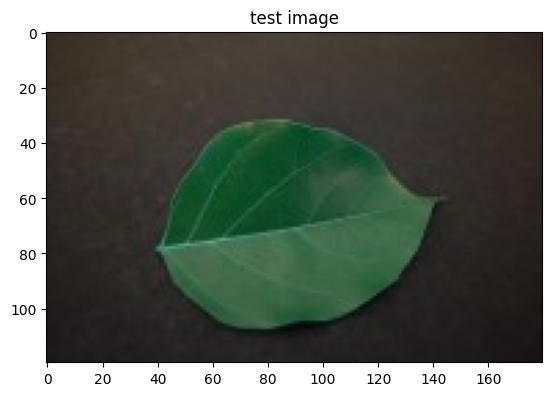

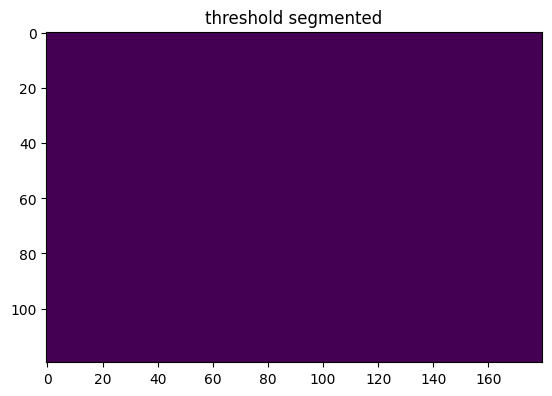

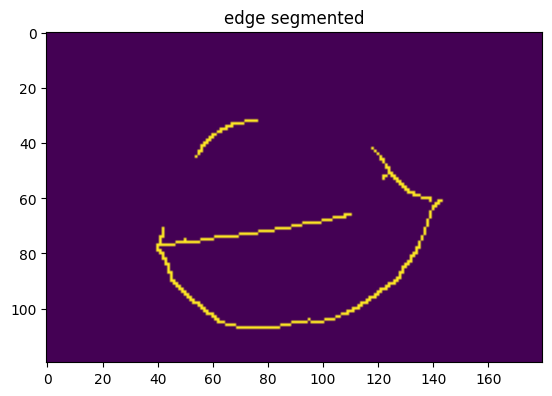

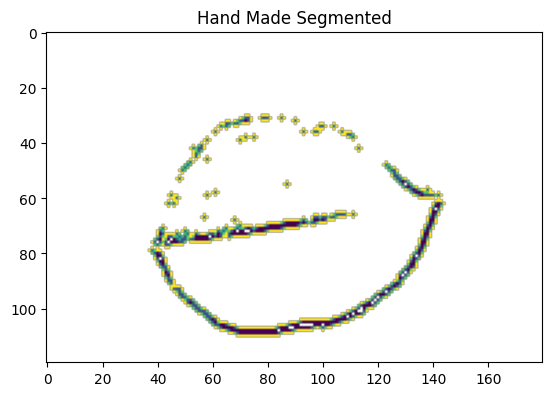

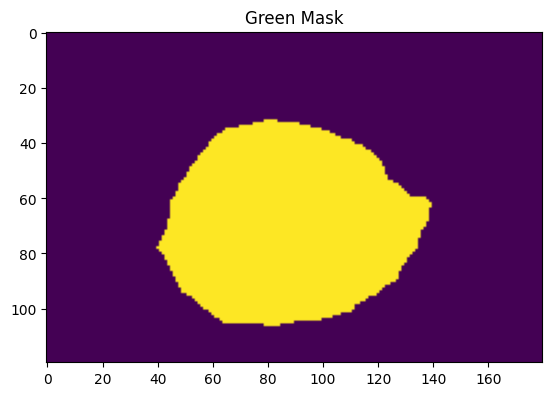

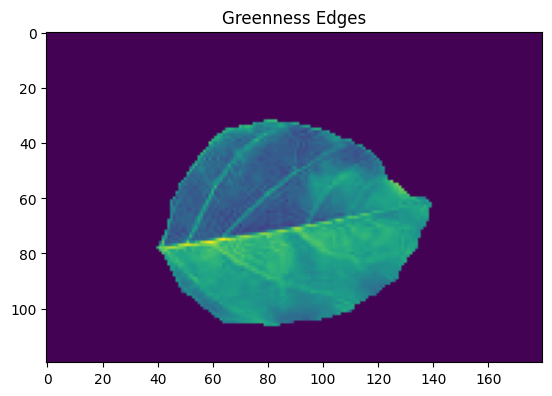

In [5]:
# Testing some of the segmentation code
# Will be removed later

test_image_path= os.path.join(PROJECT_MAP.dataDirectory, 'test.jpg')

test_image= DataProcessing.loadImage(test_image_path)
DataProcessing.displayImage(test_image, "test image")

segmented= DataProcessing.thresholdSegmentation(test_image, 150)
DataProcessing.displayImage(segmented, "threshold segmented")

edge_segmented= DataProcessing.edgeSegmentation(test_image, threshold=50)
DataProcessing.displayImage(edge_segmented, "edge segmented")

h_segmented= DataProcessing.handMadeSegmentation(test_image, 110)
DataProcessing.displayImage(h_segmented, "Hand Made Segmented")

#shows what mask output looks like
green_mask= DataProcessing.getGreennessMask(test_image)
DataProcessing.displayImage(green_mask, "Green Mask")

#shows what edges with CLAHE after greenness mask will look like
greenness_edges = DataProcessing.getEdgesFromGreenness(test_image)
DataProcessing.displayImage(greenness_edges, "Greenness Edges")


In [6]:
training_data, val_data, testing_data, classes = DataProcessing.loadAllDatasets(PROJECT_MAP.dataDirectory)
print(f'Classes: {classes}')
print(f'Len Classes: {len(classes)}')

for image, label in training_data.take(10):
    print("Label:", label.numpy())
#Creating dual sets
train_dual = DataProcessing.create_dual_input_dataset(training_data, DataProcessing.getEdgesFromGreenness)
val_dual = DataProcessing.create_dual_input_dataset(val_data, DataProcessing.getEdgesFromGreenness)
test_dual = DataProcessing.create_dual_input_dataset(testing_data, DataProcessing.getEdgesFromGreenness)

for (inputs, label) in train_dual.take(1):
    print("Raw shape:", inputs[0].shape)
    print("Mask shape:", inputs[1].shape)
    print("Label shape:", label.shape)

Found 23972 files belonging to 30 classes.
Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.
Classes: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peper chili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweet potatoes', 'tobacco', 'waterapple', 'watermelon']
Len Classes: 30
Label: 24
Label: 23
Label: 25
Label: 10
Label: 26
Label: 23
Label: 9
Label: 16
Label: 8
Label: 10
Raw shape: (32, 128, 128, 3)
Mask shape: (32, 128, 128, 1)
Label shape: (32,)


2025-07-20 21:03:30.993738: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-20 21:03:31.174829: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
for image, label in training_data.take(10):
    print("Label:", label.numpy())

Label: 3
Label: 29
Label: 27
Label: 27
Label: 29
Label: 15
Label: 7
Label: 22
Label: 15
Label: 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.939..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..135.22101].
Clipping input da

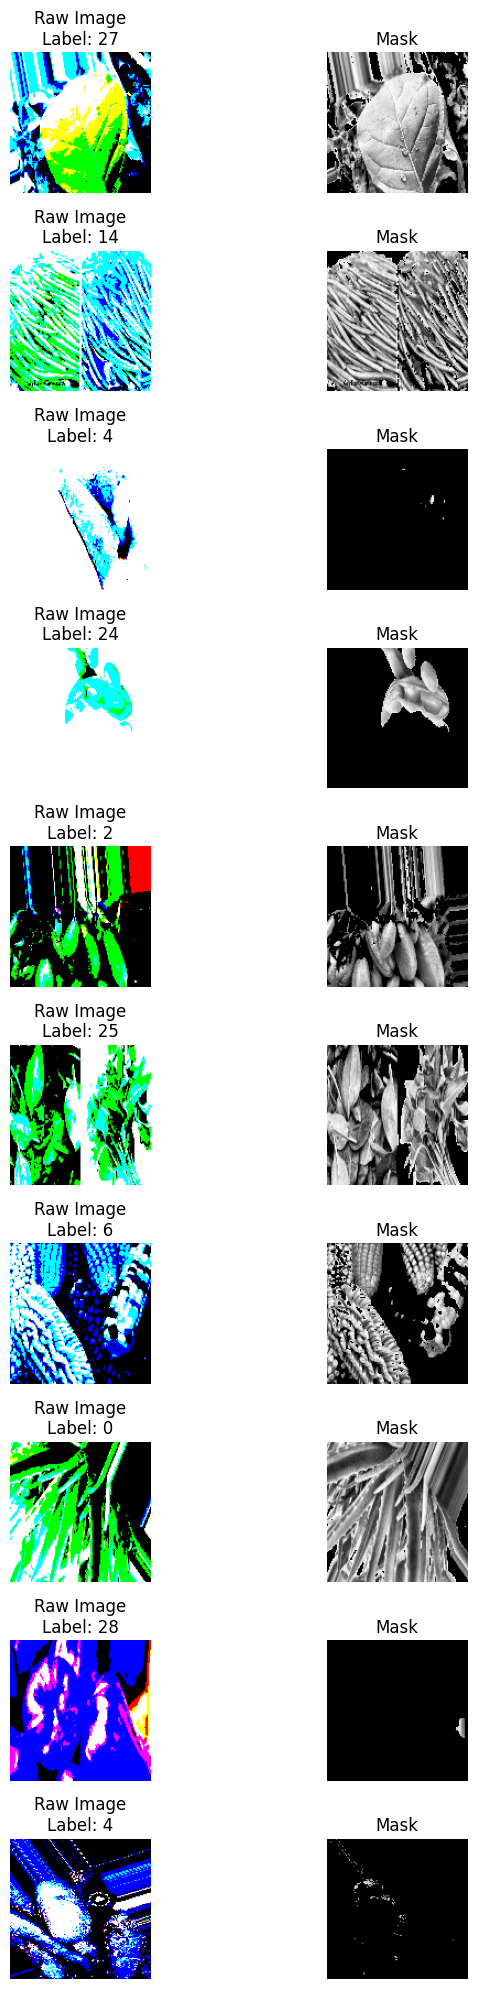

In [8]:
DataProcessing.displayProcessedImages(train_dual, 10)

In [9]:
#dual model will use both VGG19 preprocessed images and greenness threshold segmented images
#Since the outputs of each layer would potentially be different and to minimize covariate shift, we add batchnormalization: https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
#This is crucial because we are self segmenting a dataset that was not preprocessed and using a separate branch that is VGG19 preprocessed. When merging, the values can't be too different
dual_model = DualInputModel.DualInputModel(num_classes=30)
dual_model.buildModel()

training_metrics= [
    'accuracy',
    keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top_3_accuracy'),
    keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
]

dual_model.compileModel(metrics=training_metrics)
training_results= dual_model.trainModel(train_dual, val_data=val_dual, epochs=10) 
test_predictions, labels, test_accuracy, test_report= dual_model.testModel(test_dual)

Model compiled
Epoch 1/10


I0000 00:00:1753059813.454720   79648 service.cc:152] XLA service 0x7fa0f4003aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753059813.454740   79648 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-07-20 21:03:33.587445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753059813.916153   79648 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-20 21:03:34.841577: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 188 bytes spill stores, 188 bytes spill loads

2025-07-20 21:03:35.238937: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

  6/750 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.0152 - loss: 7.9380 - top_10_accuracy: 0.3577 - top_3_accuracy: 0.0152

I0000 00:00:1753059823.312807   79648 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


746/750 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3897 - loss: 2.3719 - top_10_accuracy: 0.8090 - top_3_accuracy: 0.3897

2025-07-20 21:04:09.910621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1634', 8 bytes spill stores, 8 bytes spill loads

2025-07-20 21:04:09.912034: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 104 bytes spill stores, 104 bytes spill loads

2025-07-20 21:04:10.270520: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1620', 8 bytes spill stores, 8 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3906 - loss: 2.3676 - top_10_accuracy: 0.8096 - top_3_accuracy: 0.3906

2025-07-20 21:04:21.817538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_353', 200 bytes spill stores, 200 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 52s 54ms/step - accuracy: 0.3908 - loss: 2.3665 - top_10_accuracy: 0.8098 - top_3_accuracy: 0.3908 - val_accuracy: 0.7627 - val_loss: 0.7483 - val_top_10_accuracy: 0.9888 - val_top_3_accuracy: 0.7627
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.7480 - loss: 0.8130 - top_10_accuracy: 0.9853 - top_3_accuracy: 0.7480 - val_accuracy: 0.8059 - val_loss: 0.5760 - val_top_10_accuracy: 0.9947 - val_top_3_accuracy: 0.8059
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.8214 - loss: 0.5674 - top_10_accuracy: 0.9936 - top_3_accuracy: 0.8214 - val_accuracy: 0.8571 - val_loss: 0.4426 - val_top_10_accuracy: 0.9974 - val_top_3_accuracy: 0.8571
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.8578 - loss: 0.4405 - top_10_accuracy: 0.9963 - top_3_accuracy: 0.8578 - val_accuracy: 0.8644 - val_loss: 0.4245 - val_top_10_accuracy: 0.9983 - val_top_3_accuracy: 0.8644
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/st

2025-07-20 21:09:25.370189: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


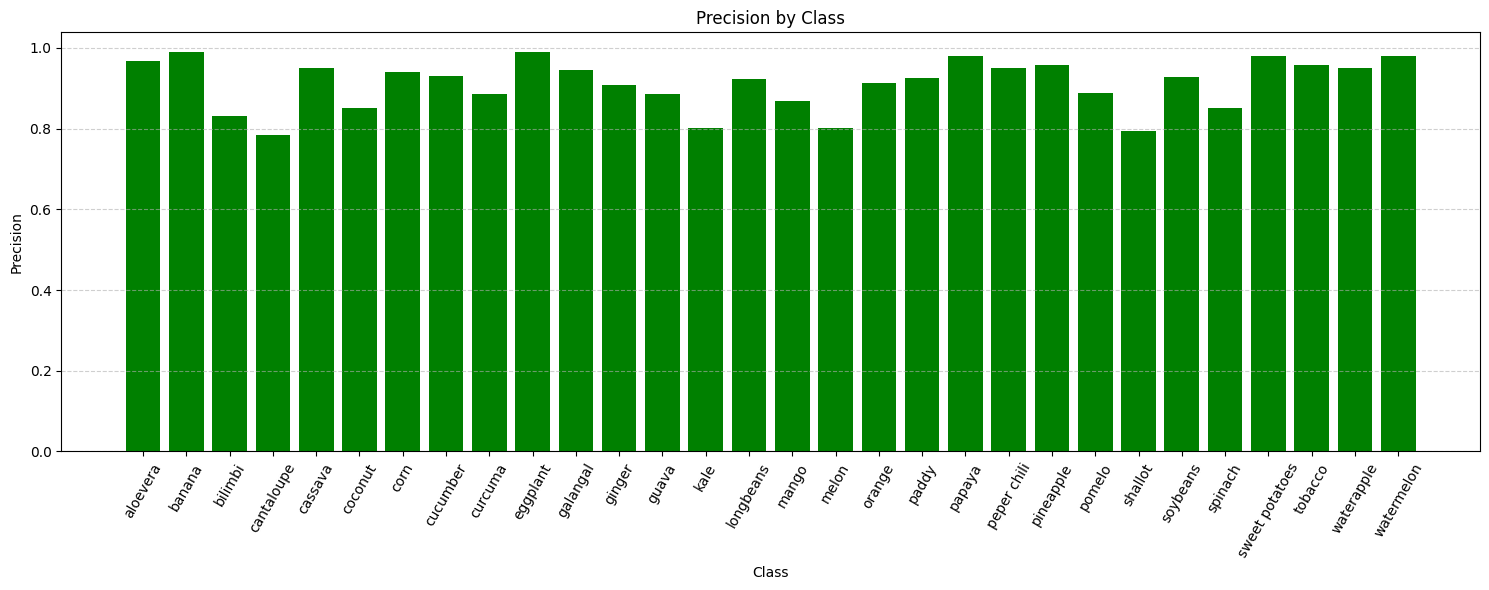

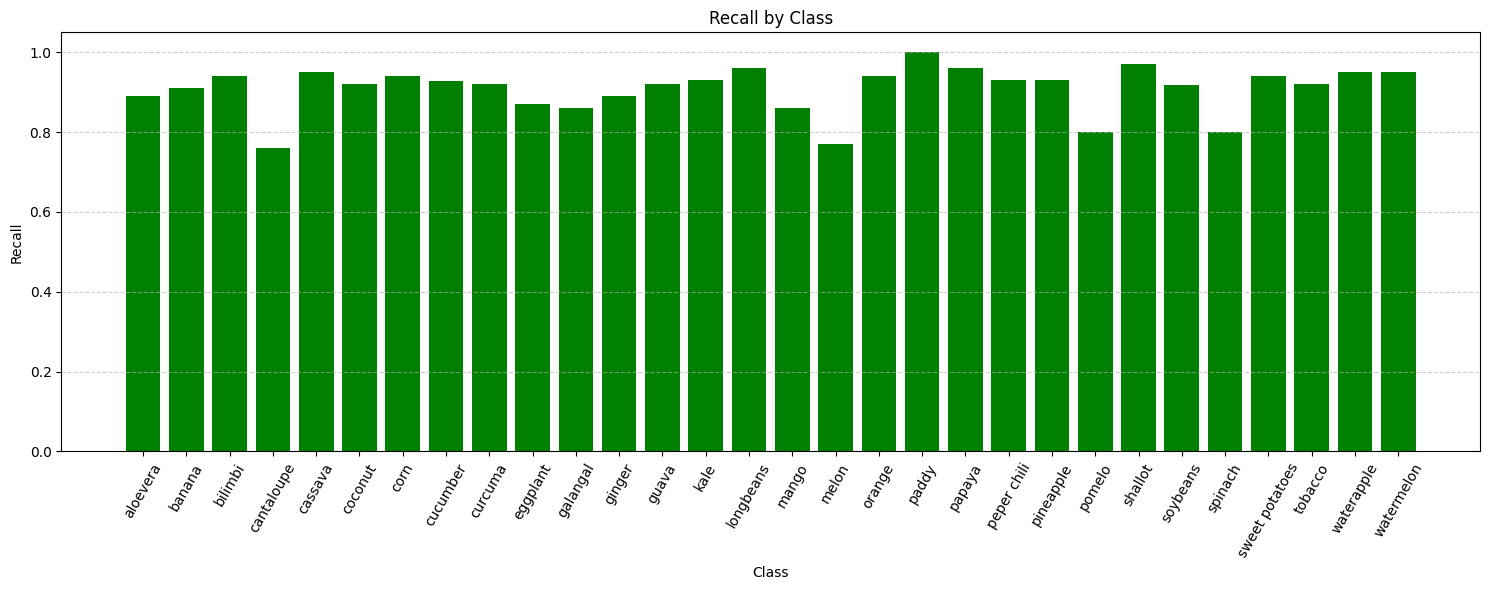

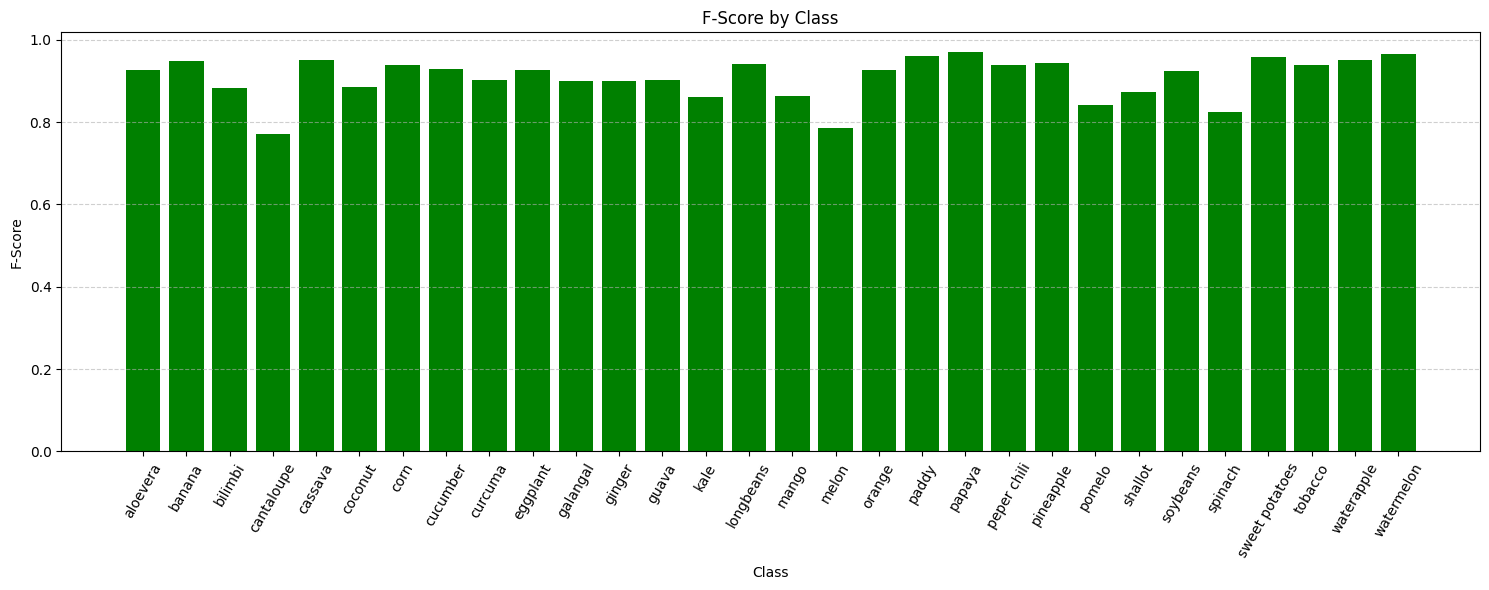

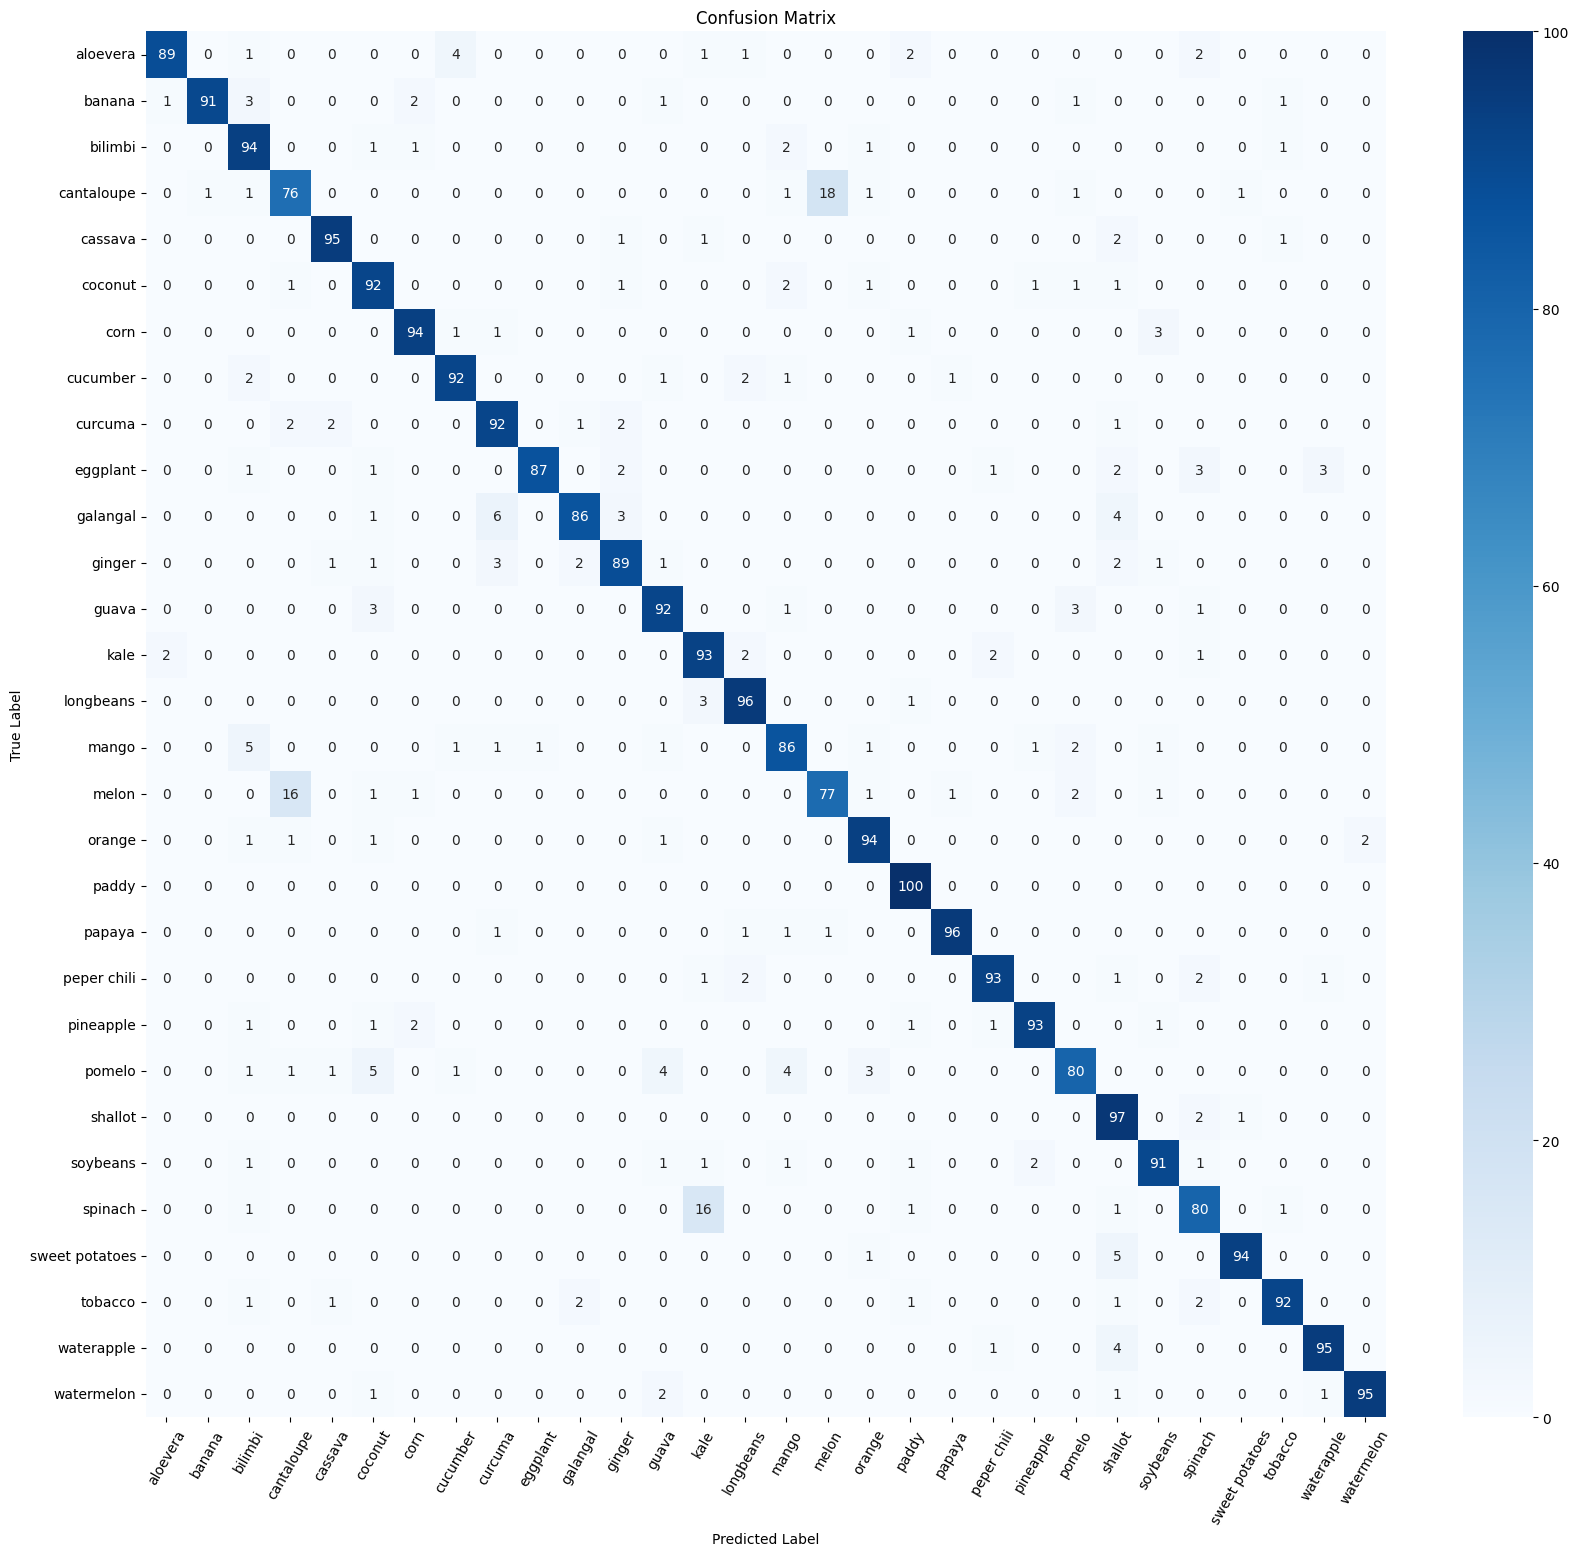

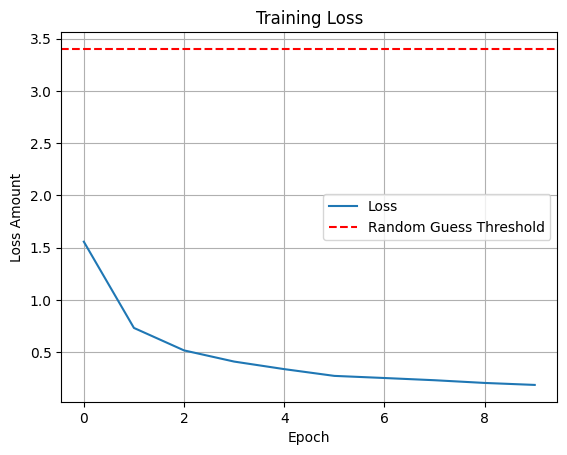

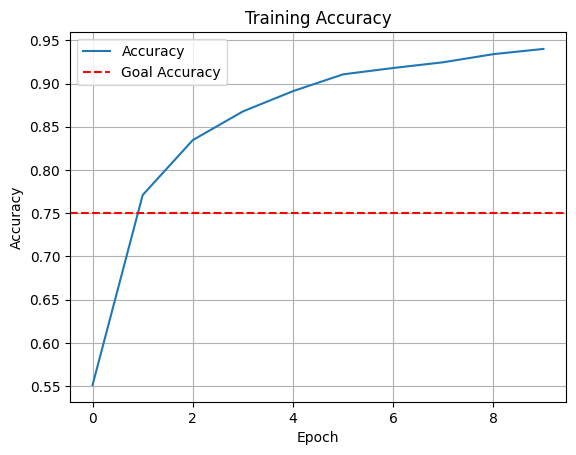

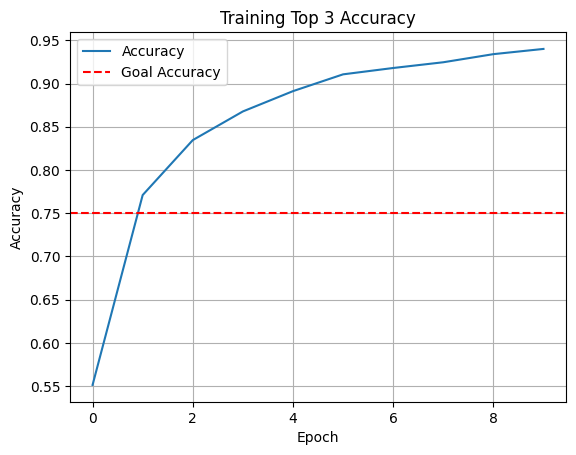

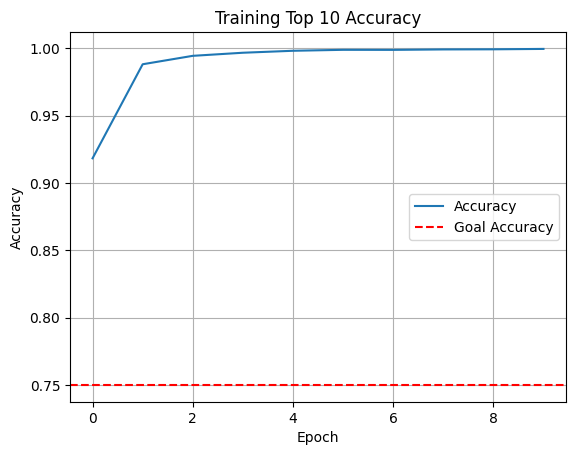

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        320 │ mask_input[0][0]

 Total params: 20,858,396 (79.57 MB)

 Trainable params: 277,854 (1.06 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 555,710 (2.12 MB)

In [10]:
# make some graphs and whatnot for analysis
# Most of the function are defined in the Analysis.py file
import Analysis
    
class_names= training_data.class_names

training_loss= training_results.history['loss']
training_accuracy= training_results.history["accuracy"]
top_3_accuracy= training_results.history["top_3_accuracy"]
top_10_accuracy= training_results.history['top_10_accuracy']

precision, recall, fscore, support= Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model.model.summary()


In [20]:
#creating a new object, since we may want to reuse the non-tuned model. This will allow us to train and compare either
dual_model_best = DualInputModel.DualInputModel(num_classes=30)
best_model_best = dual_model_best.optimize_hyperparameters(train_dual, val_dual, test_dual, model_builder=dual_model_best.buildHPModel)

#Grab untrained hyperparameters
best_hps = dual_model_best.tuner.get_best_hyperparameters(1)[0]
untrained_model = dual_model_best.buildHPModel(best_hps)
dual_model_best.model = untrained_model
training_results_best = dual_model_best.trainModel(train_dual, val_data=val_dual, epochs=10)
test_predictions, labels, test_accuracy, test_report= dual_model_best.testModel(test_dual)

Reloading Tuner from plant_tuner/plant_model/tuner0.json
Results summary
Results in plant_tuner/plant_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
dense1_units: 192
dense2_units: 192
dense3_units: 256
dropout1: 0.2
dense4_units: 64
dropout2: 0.4
learning_rate: 0.001
Score: 0.9085808396339417

Trial 03 summary
Hyperparameters:
dense1_units: 256
dense2_units: 64
dense3_units: 512
dropout1: 0.4
dense4_units: 64
dropout2: 0.2
learning_rate: 0.001
Score: 0.9049504995346069

Trial 04 summary
Hyperparameters:
dense1_units: 192
dense2_units: 192
dense3_units: 128
dropout1: 0.30000000000000004
dense4_units: 64
dropout2: 0.30000000000000004
learning_rate: 0.001
Score: 0.8947194814682007

Trial 08 summary
Hyperparameters:
dense1_units: 64
dense2_units: 128
dense3_units: 384
dropout1: 0.4
dense4_units: 64
dropout2: 0.1
learning_rate: 0.001
Score: 0.89207923412323

Trial 01 summary
Hyperparameters:
dense1_units: 192
dense2_units: 12

/home/codyrgould/tf-gpu/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.2912 - loss: 2.7150 - top_10_accuracy: 0.7158 - top_3_accuracy: 0.4751 - val_accuracy: 0.7578 - val_loss: 0.7997 - val_top_10_accuracy: 0.9792 - val_top_3_accuracy: 0.9142
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.7007 - loss: 0.9951 - top_10_accuracy: 0.9714 - top_3_accuracy: 0.8873 - val_accuracy: 0.7977 - val_loss: 0.6600 - val_top_10_accuracy: 0.9881 - val_top_3_accuracy: 0.9399
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.7938 - loss: 0.6921 - top_10_accuracy: 0.9867 - top_3_accuracy: 0.9331 - val_accuracy: 0.8502 - val_loss: 0.4926 - val_top_10_accuracy: 0.9934 - val_top_3_accuracy: 0.9634
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.8385 - loss: 0.5291 - top_10_accuracy: 0.9919 - top_3_accuracy: 0.9563 - val_accuracy: 0.8683 - val_loss: 0.4250 - val_top_10_accuracy: 0.9974 - val_top_3_accuracy: 0.9719
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 

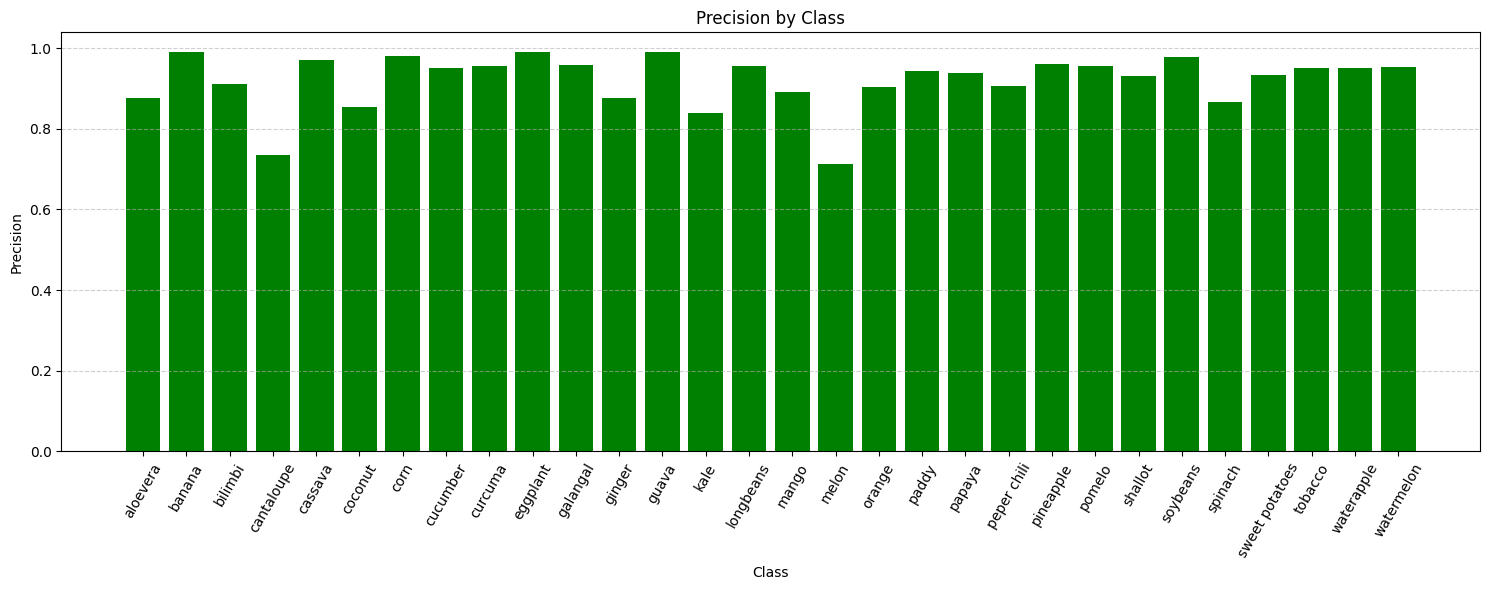

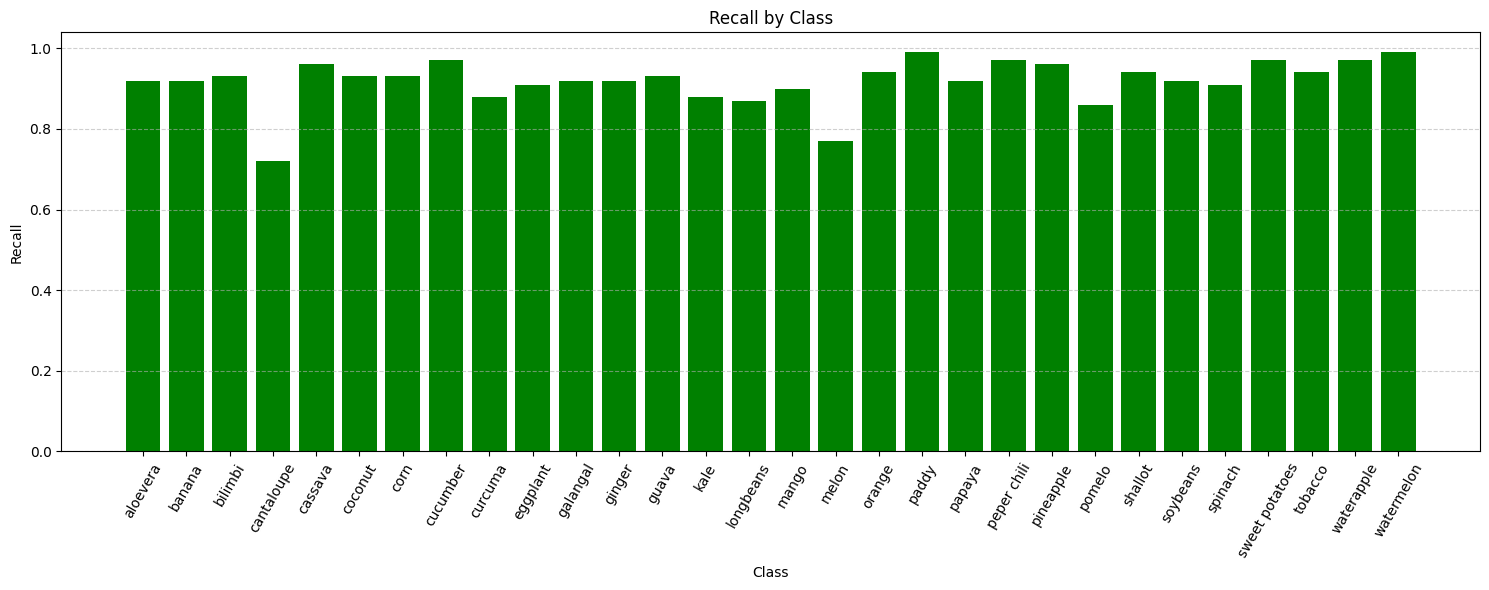

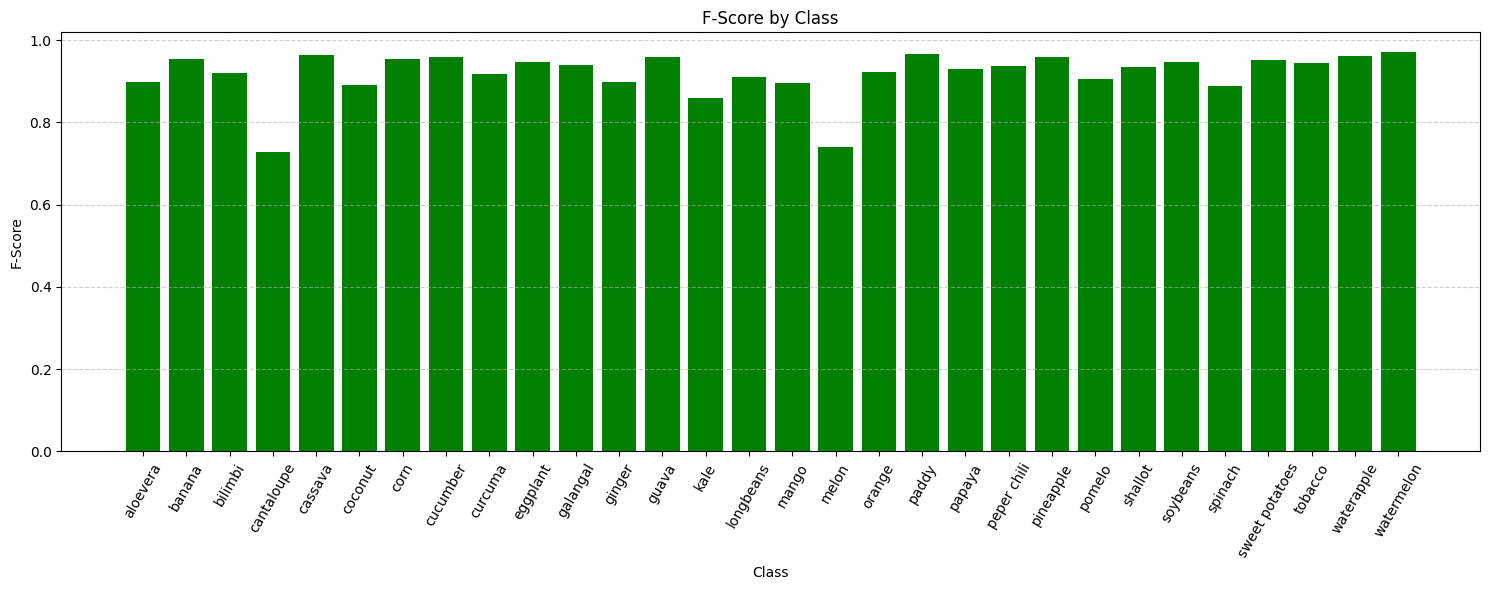

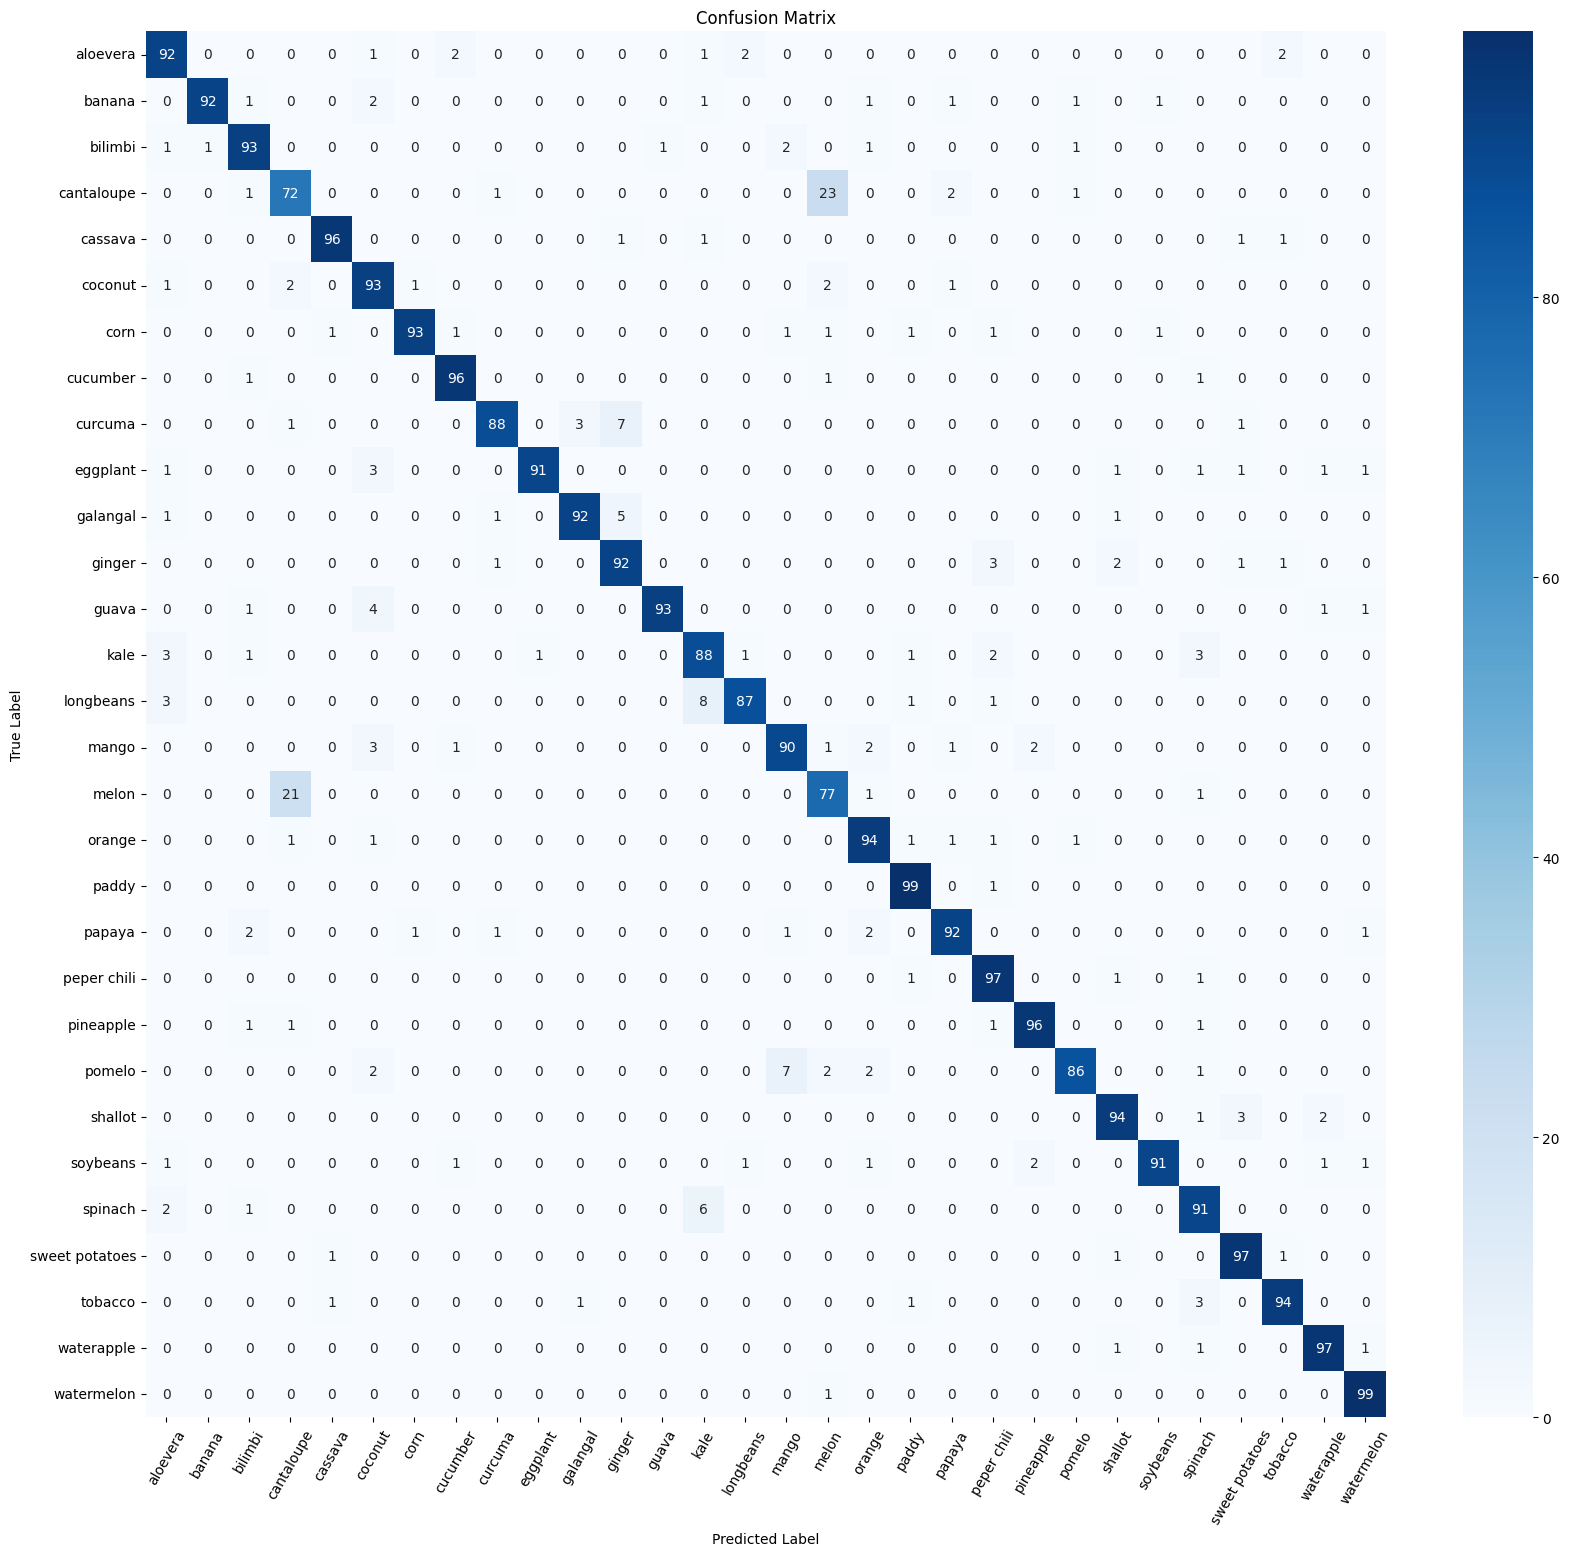

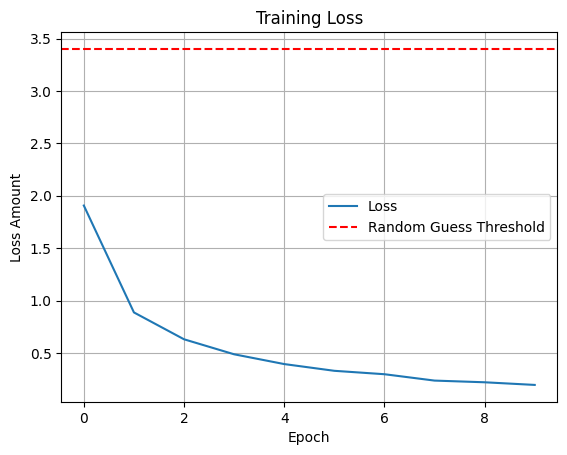

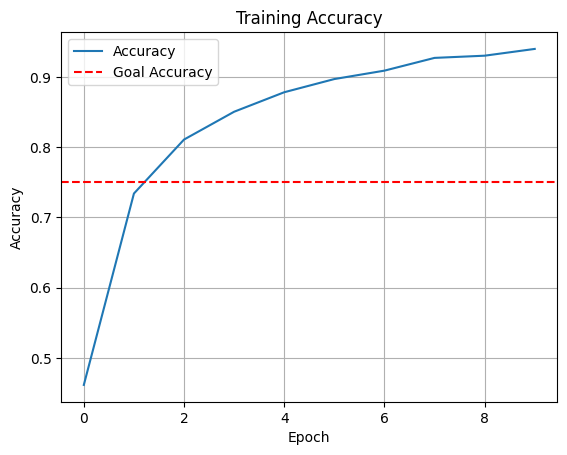

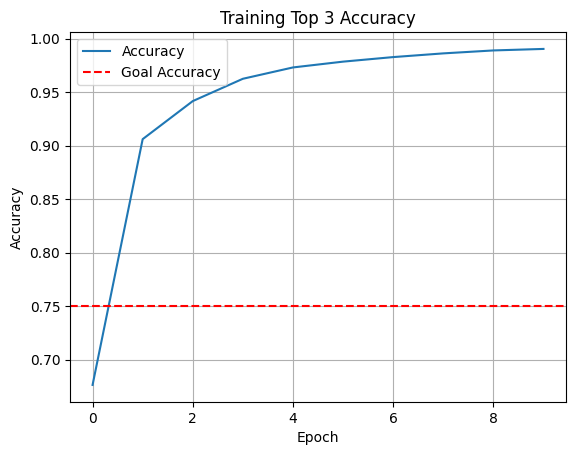

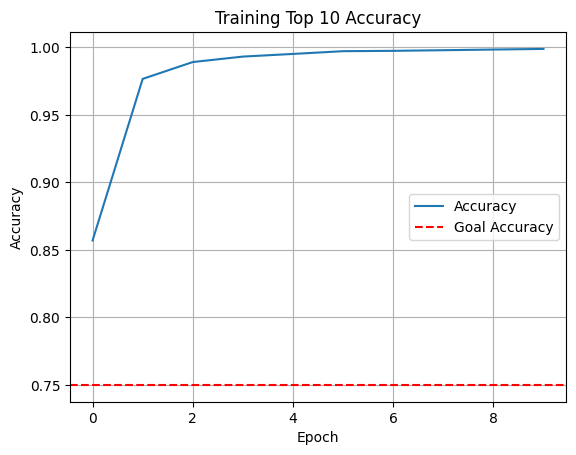

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        320 │ mask_input[0][0]

 Total params: 21,024,860 (80.20 MB)

 Trainable params: 333,342 (1.27 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 666,686 (2.54 MB)

In [21]:
class_names= training_data.class_names

training_loss= training_results_best.history['loss']
training_accuracy= training_results_best.history["accuracy"]
top_3_accuracy= training_results_best.history["top_3_accuracy"]
top_10_accuracy= training_results_best.history['top_10_accuracy']

precision, recall, fscore, support= Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model_best.model.summary()

In [22]:
dual_model_best.model.save("best_plant_model.keras")

In [23]:
#Attempt with adaptive segmentation
importlib.reload(DataProcessing)
adaptive_train_dual = DataProcessing.create_dual_input_dataset(training_data, DataProcessing.adaptive_segmentation)
adaptive_val_dual = DataProcessing.create_dual_input_dataset(val_data, DataProcessing.adaptive_segmentation)
adaptive_test_dual = DataProcessing.create_dual_input_dataset(testing_data, DataProcessing.adaptive_segmentation)

for (inputs, label) in train_dual.take(1):
    print("Raw shape:", inputs[0].shape)
    print("Mask shape:", inputs[1].shape)
    print("Label shape:", label.shape)

Raw shape: (32, 128, 128, 3)
Mask shape: (32, 128, 128, 1)
Label shape: (32,)


2025-07-20 22:26:29.653697: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-99.939..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-111.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..148.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..133.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-107.68..134.061].
Clipping input data 

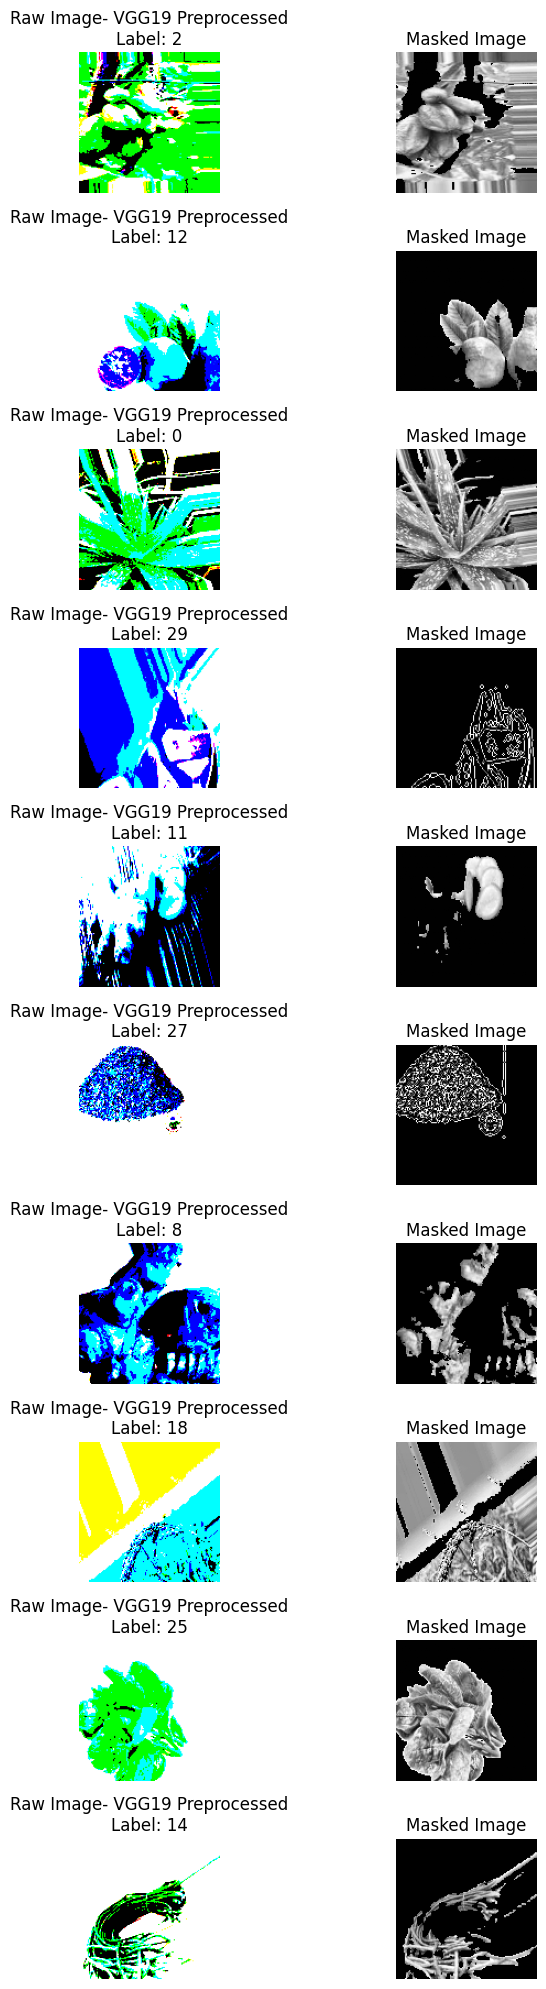

In [27]:
DataProcessing.displayProcessedImages(adaptive_train_dual, 10)

In [33]:
#Grab untrained hyperparameters
best_hps = dual_model_best.tuner.get_best_hyperparameters(1)[0]
untrained_model = dual_model_best.buildHPModel(best_hps)
dual_model_best.model = untrained_model

adaptive_segmentation_results = dual_model_best.trainModel(adaptive_train_dual, epochs=10, val_data=adaptive_val_dual)
test_predictions, labels, test_accuracy, test_report= dual_model_best.testModel(adaptive_test_dual)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.2831 - loss: 2.7783 - top_10_accuracy: 0.7165 - top_3_accuracy: 0.4774 - val_accuracy: 0.7475 - val_loss: 0.8280 - val_top_10_accuracy: 0.9815 - val_top_3_accuracy: 0.9182
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.6976 - loss: 1.0210 - top_10_accuracy: 0.9701 - top_3_accuracy: 0.8897 - val_accuracy: 0.8178 - val_loss: 0.5930 - val_top_10_accuracy: 0.9934 - val_top_3_accuracy: 0.9475
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.7943 - loss: 0.6909 - top_10_accuracy: 0.9858 - top_3_accuracy: 0.9350 - val_accuracy: 0.8485 - val_loss: 0.4944 - val_top_10_accuracy: 0.9954 - val_top_3_accuracy: 0.9667
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.8440 - loss: 0.5086 - top_10_accuracy: 0.9921 - top_3_accuracy: 0.9578 - val_accuracy: 0.8733 - val_loss: 0.4048 - val_top_10_accuracy: 0.9974 - val_top_3_accuracy: 0.9746
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 

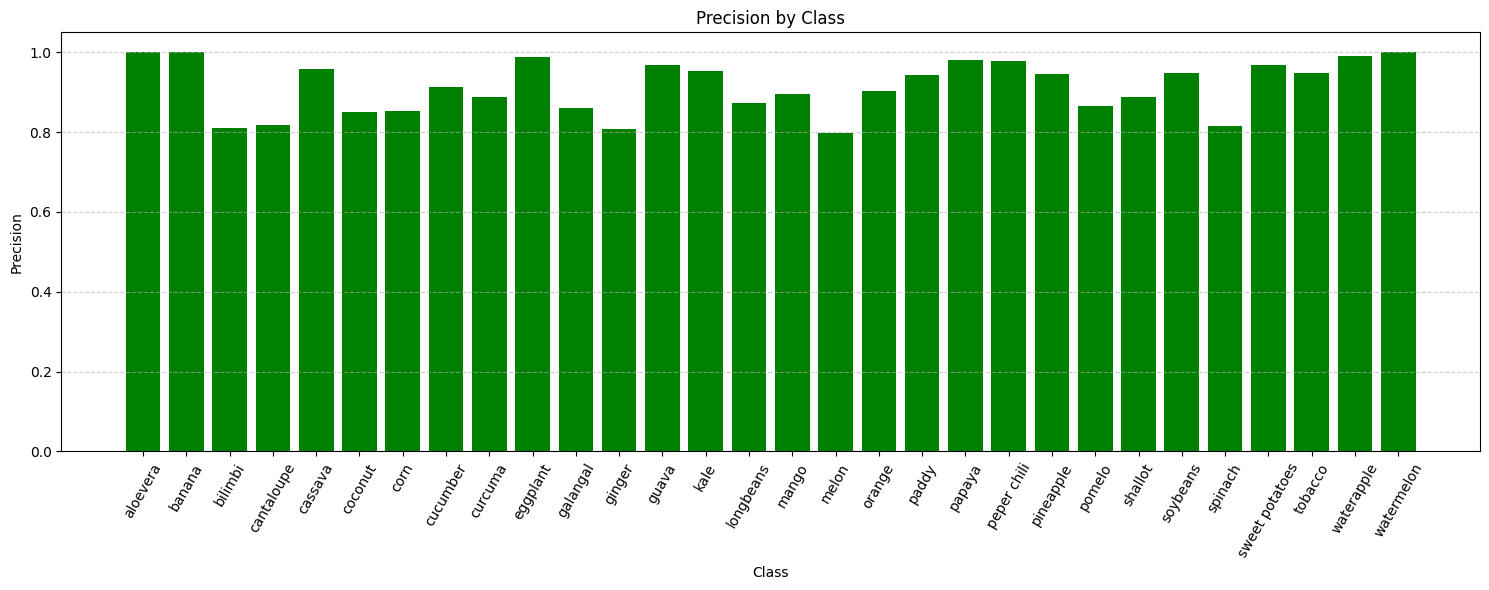

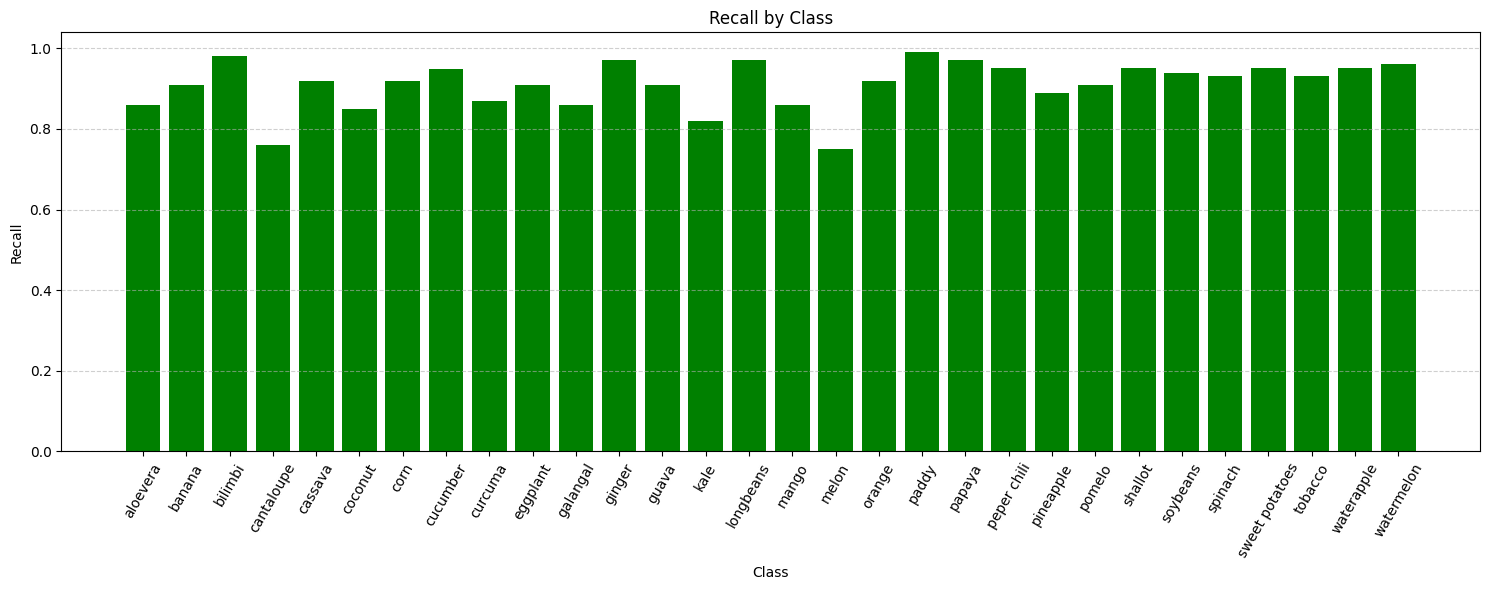

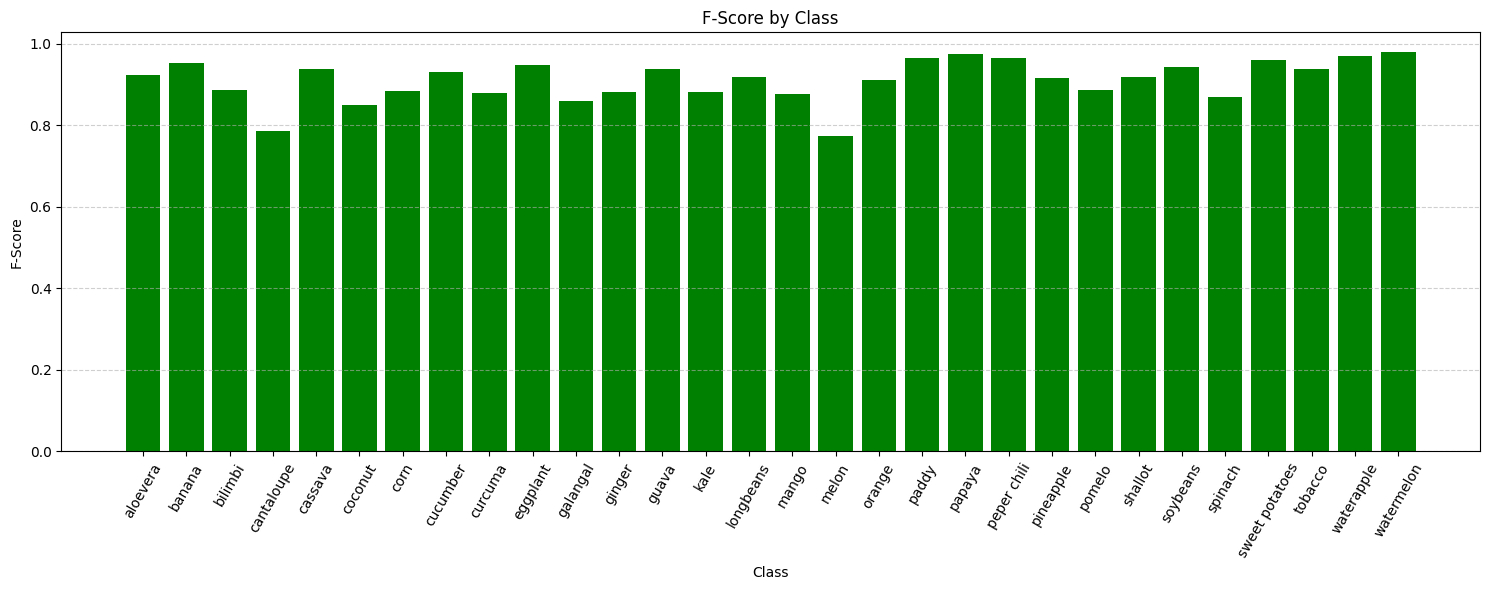

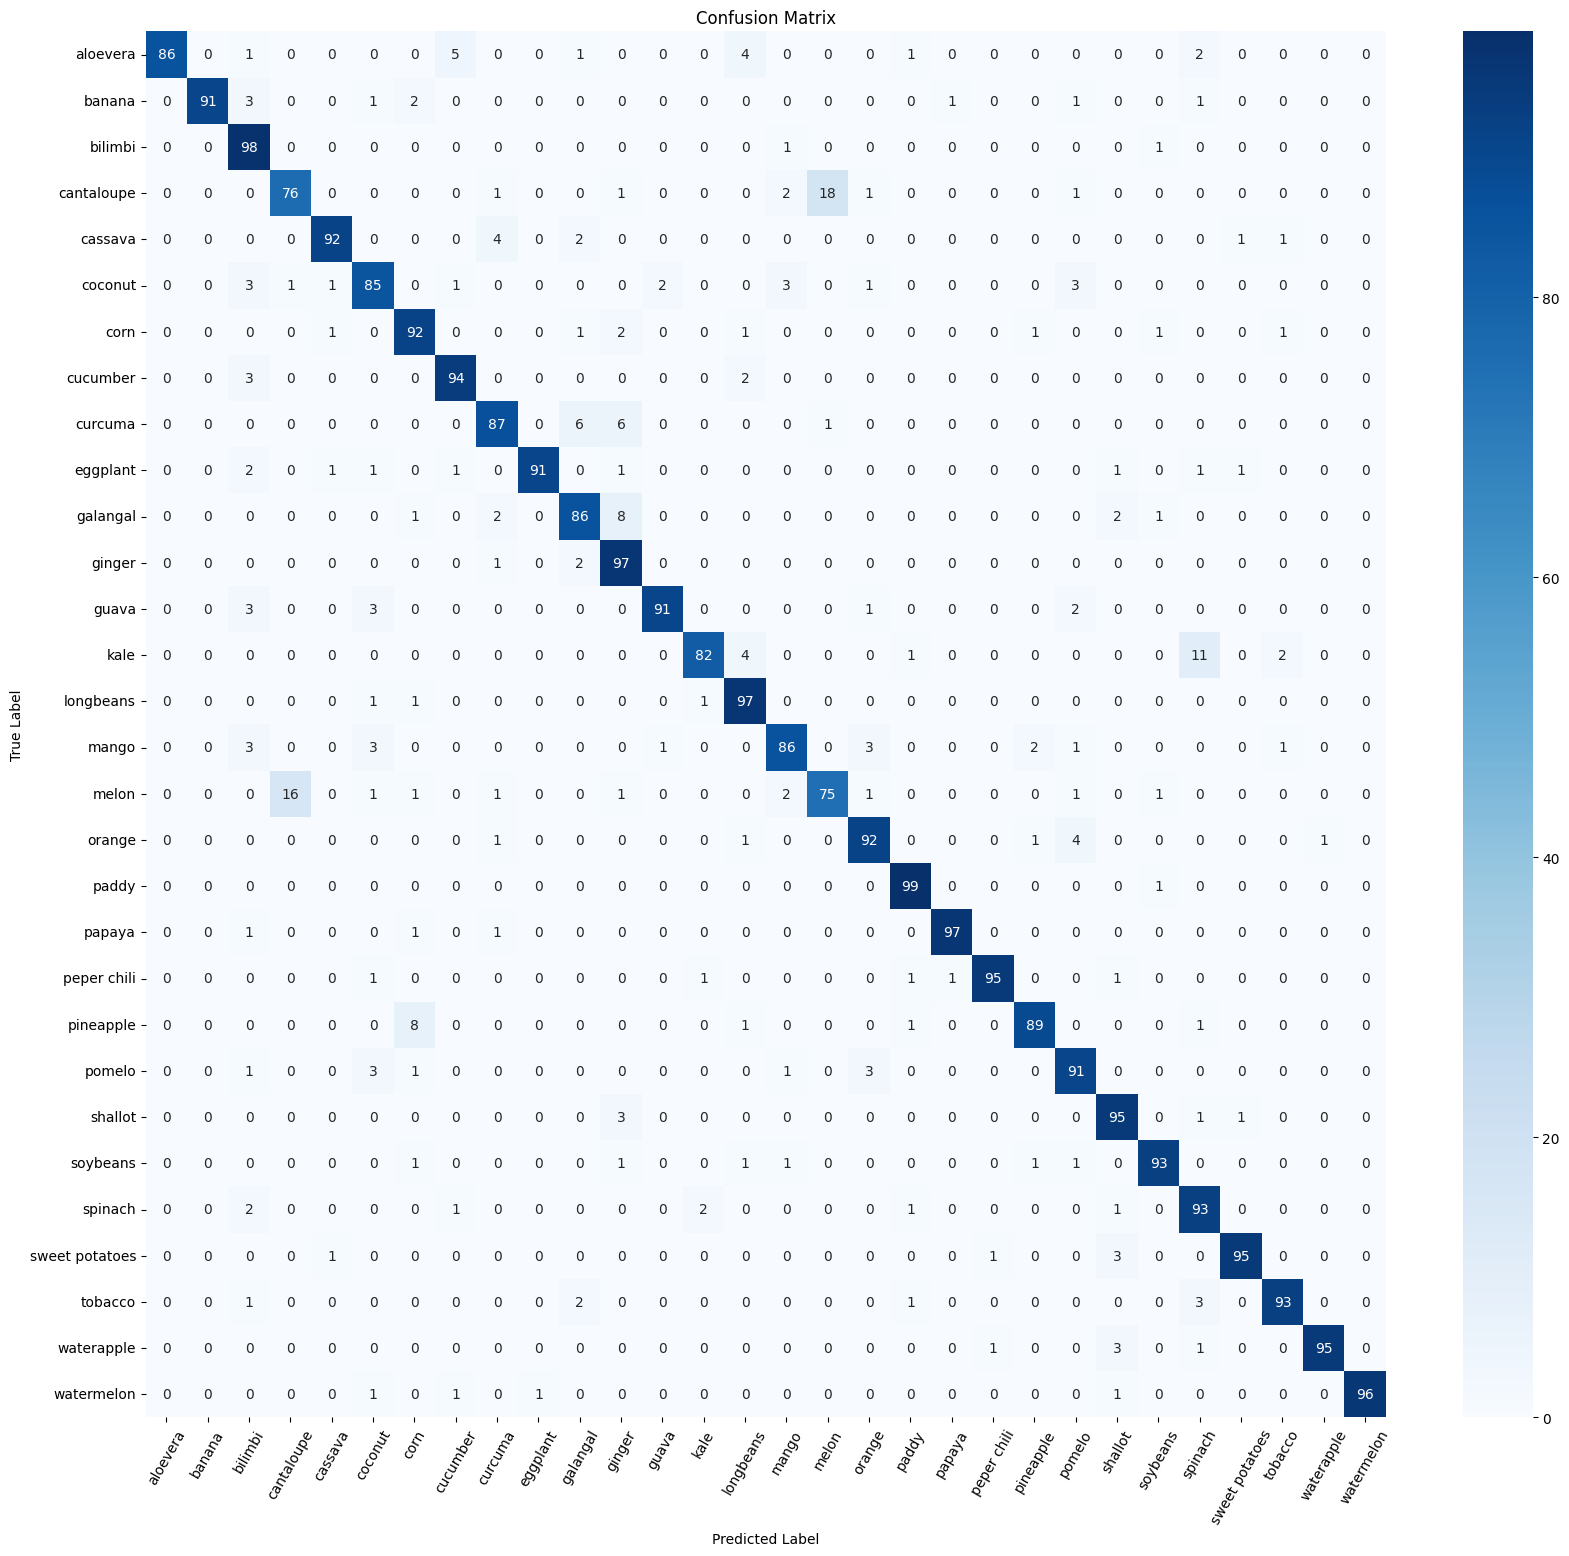

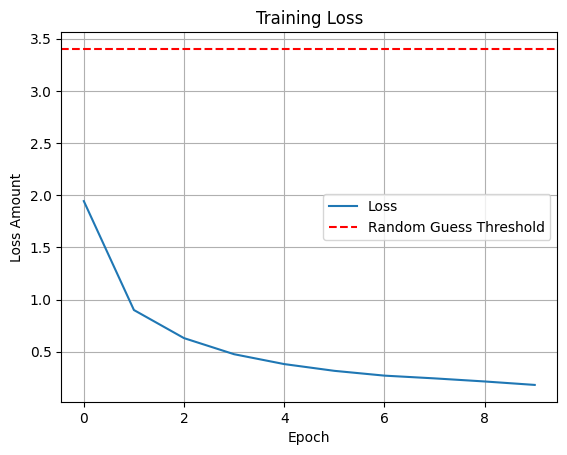

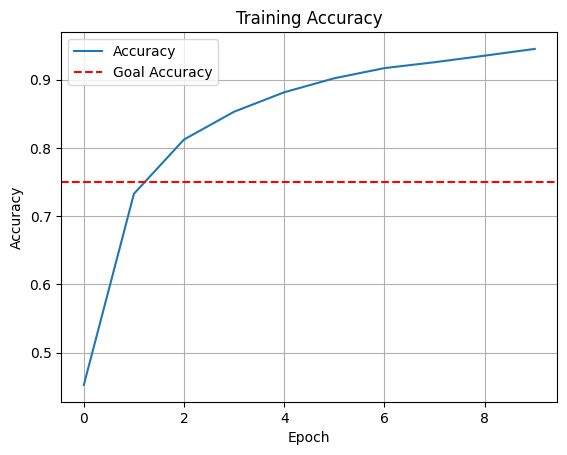

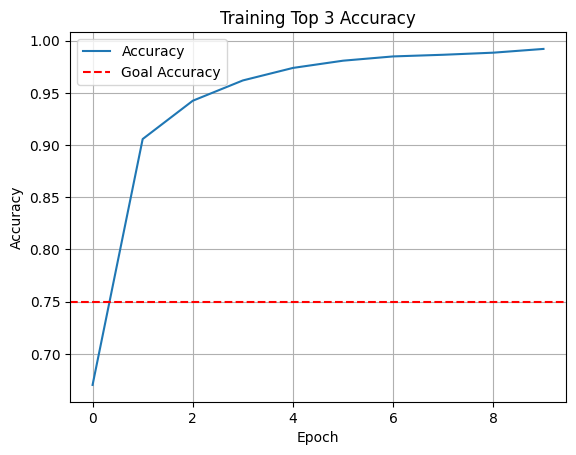

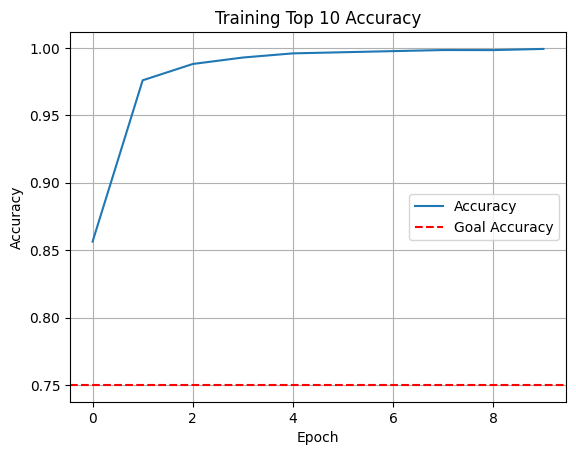

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        320 │ mask_input[0][0]

 Total params: 21,024,860 (80.20 MB)

 Trainable params: 333,342 (1.27 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 666,686 (2.54 MB)

In [34]:
class_names = training_data.class_names

training_loss = adaptive_segmentation_results.history['loss']
training_accuracy = adaptive_segmentation_results.history["accuracy"]
top_3_accuracy = adaptive_segmentation_results.history["top_3_accuracy"]
top_10_accuracy = adaptive_segmentation_results.history['top_10_accuracy']

precision, recall, fscore, support = Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model_best.model.summary()

In [35]:
#saving at 10 epochs
dual_model_best.model.save("adative_best_plant_model.keras")

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9444 - loss: 0.1922 - top_10_accuracy: 0.9991 - top_3_accuracy: 0.9914 - val_accuracy: 0.9089 - val_loss: 0.3787 - val_top_10_accuracy: 0.9983 - val_top_3_accuracy: 0.9802
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9490 - loss: 0.1738 - top_10_accuracy: 0.9994 - top_3_accuracy: 0.9930 - val_accuracy: 0.9241 - val_loss: 0.3150 - val_top_10_accuracy: 0.9980 - val_top_3_accuracy: 0.9878
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9594 - loss: 0.1365 - top_10_accuracy: 0.9996 - top_3_accuracy: 0.9947 - val_accuracy: 0.9007 - val_loss: 0.4056 - val_top_10_accuracy: 0.9974 - val_top_3_accuracy: 0.9851
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.9586 - loss: 0.1351 - top_10_accuracy: 0.9993 - top_3_accuracy: 0.9943 - val_accuracy: 0.9241 - val_loss: 0.3389 - val_top_10_accuracy: 0.9974 - val_top_3_accuracy: 0.9888
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 4

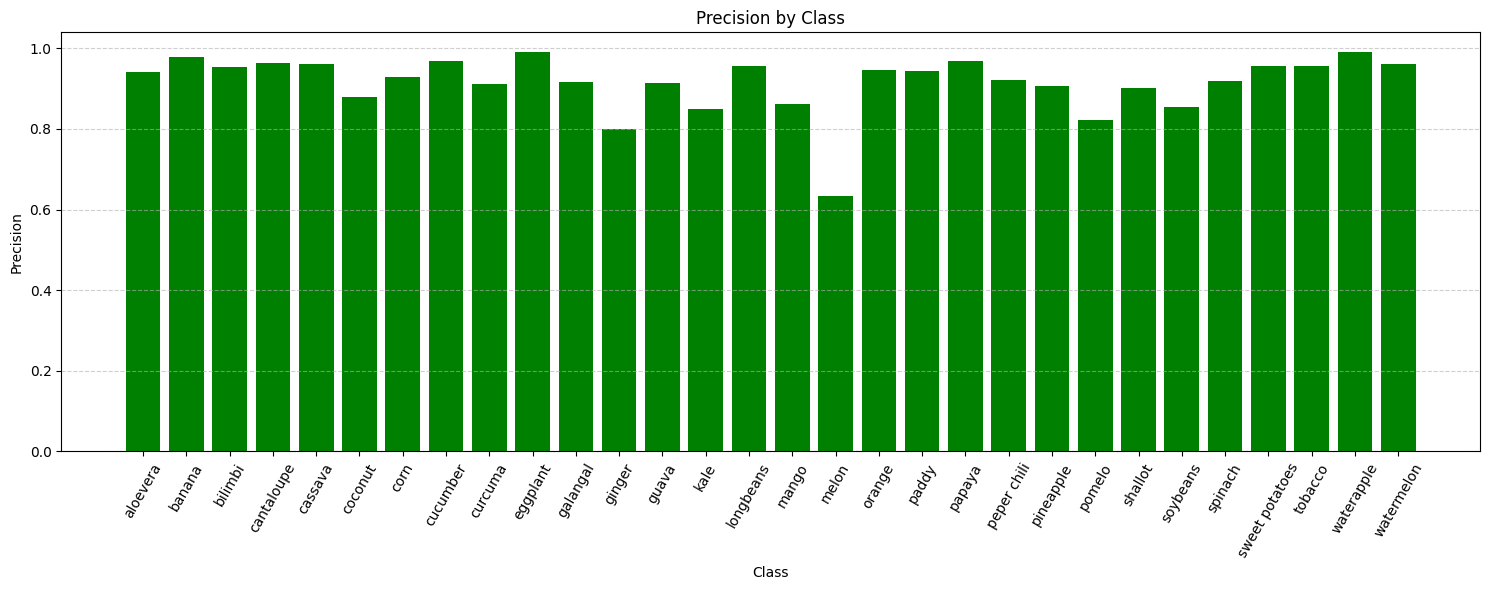

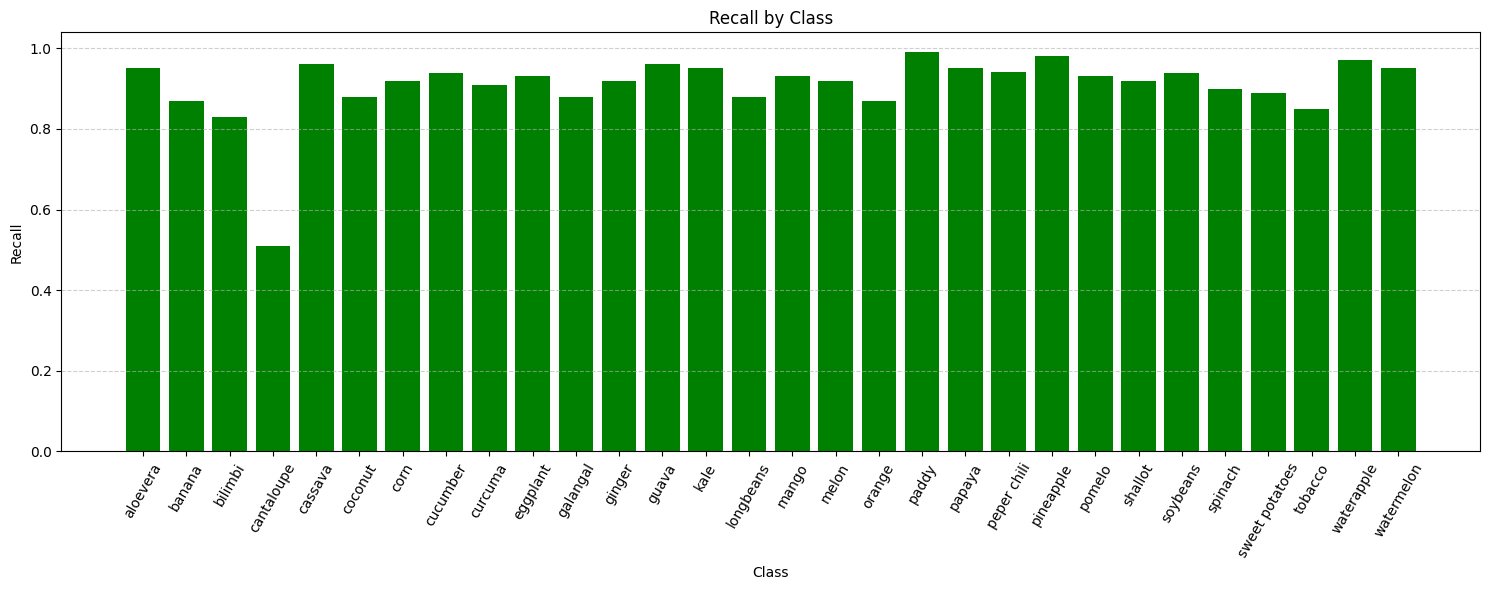

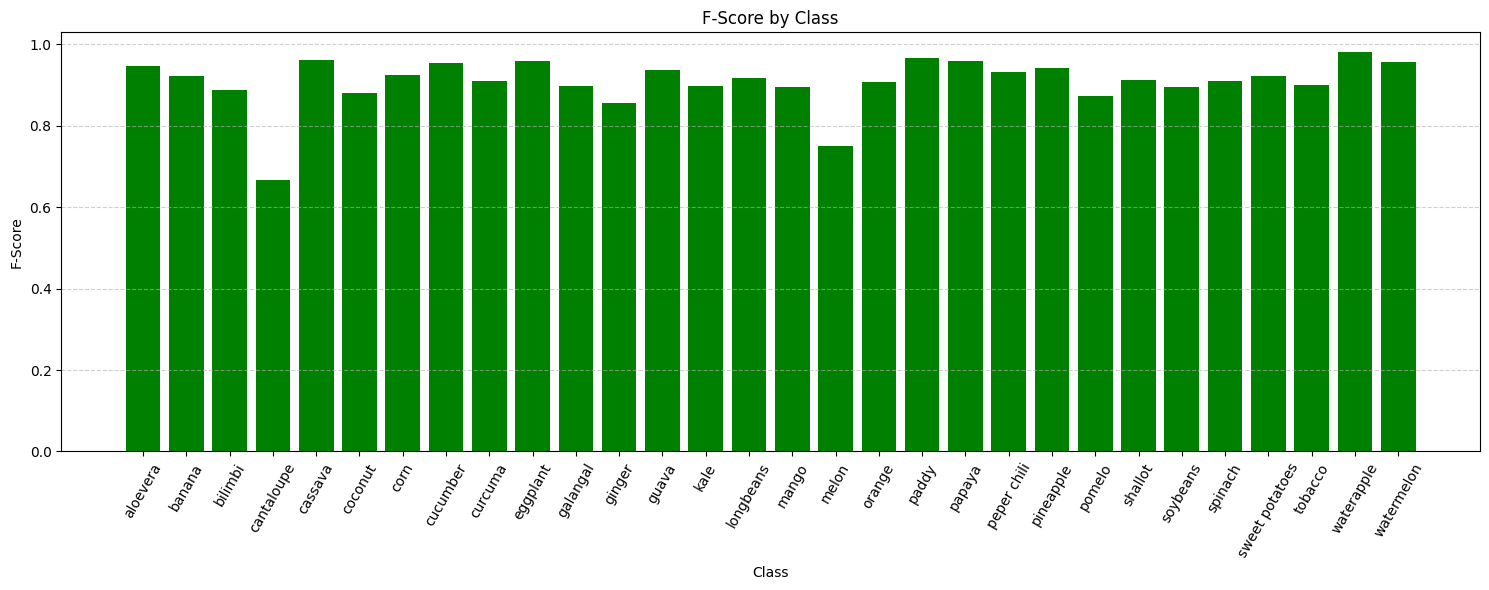

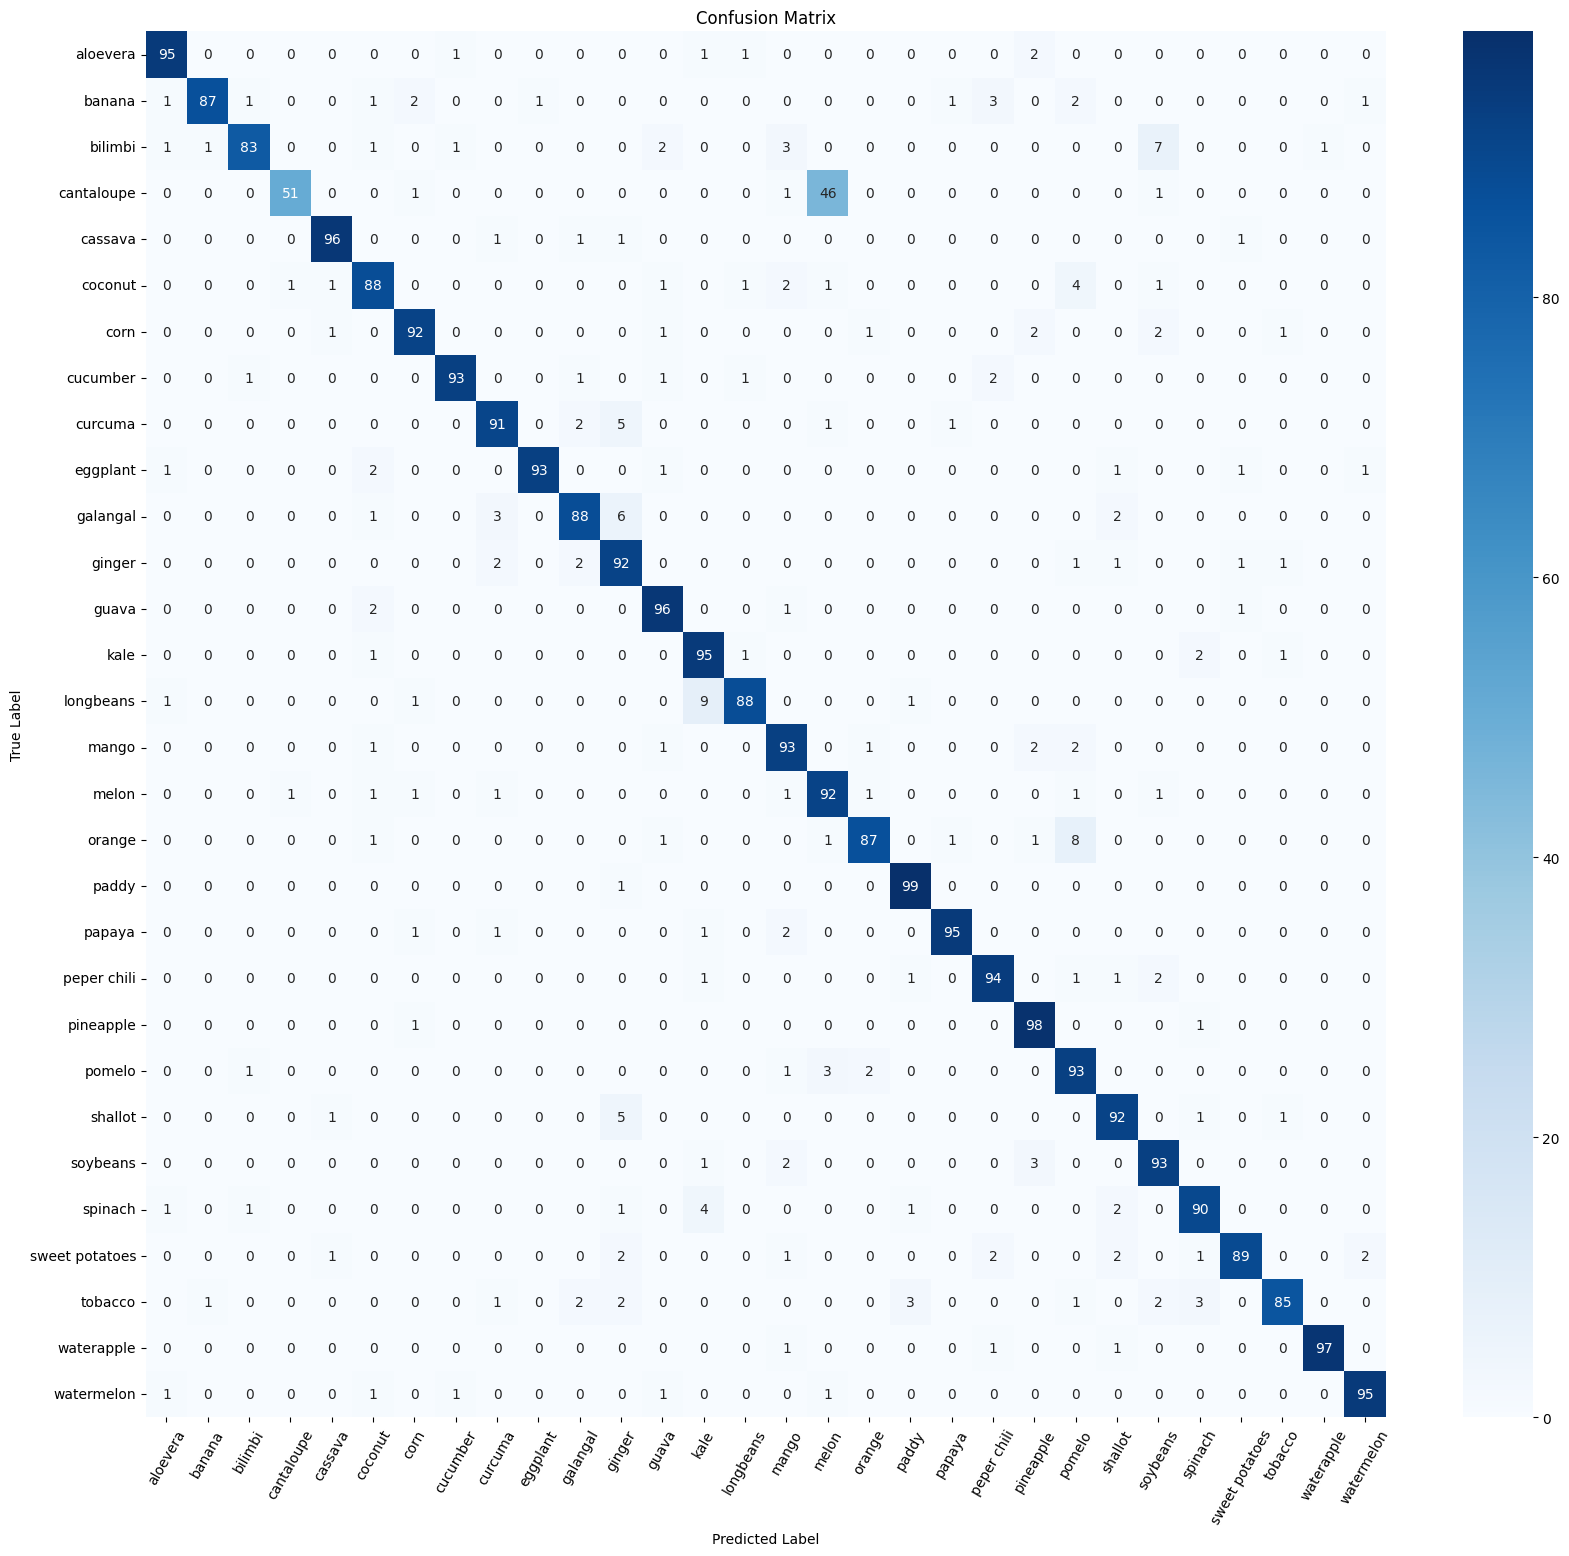

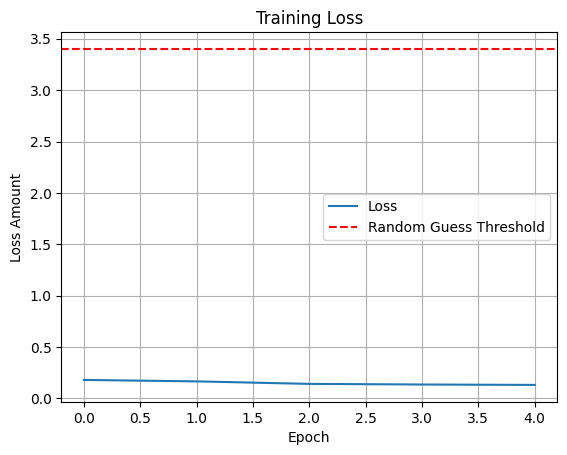

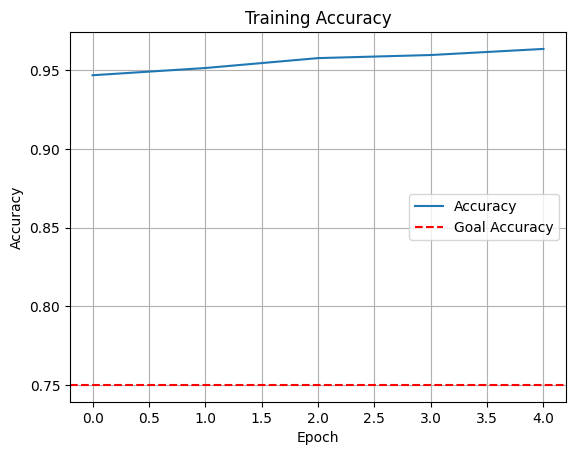

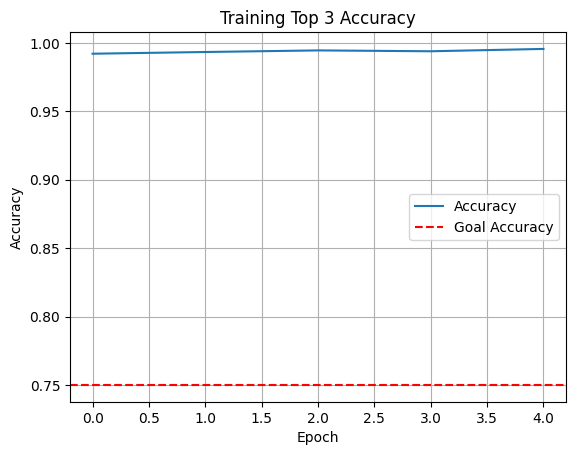

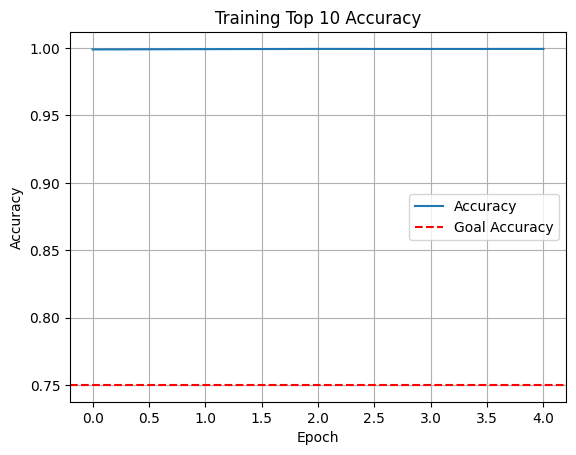

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ raw_input[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        320 │ mask_input[0][0]

 Total params: 21,024,860 (80.20 MB)

 Trainable params: 333,342 (1.27 MB)

 Non-trainable params: 20,024,832 (76.39 MB)

 Optimizer params: 666,686 (2.54 MB)

In [37]:
#Showed signs that we could continue training past 10 epochs
dual_model_best.model.load_weights("adative_best_plant_model.keras")
adaptive_segmentation_results = dual_model_best.trainModel(adaptive_train_dual, epochs=5, val_data=adaptive_val_dual)
test_predictions, labels, test_accuracy, test_report= dual_model_best.testModel(adaptive_test_dual)
class_names = training_data.class_names

training_loss = adaptive_segmentation_results.history['loss']
training_accuracy = adaptive_segmentation_results.history["accuracy"]
top_3_accuracy = adaptive_segmentation_results.history["top_3_accuracy"]
top_10_accuracy = adaptive_segmentation_results.history['top_10_accuracy']

precision, recall, fscore, support = Analysis.getTestData(test_predictions, labels)

Analysis.createBarGraph(precision, class_names, "Precision", "Precision by Class")
Analysis.createBarGraph(recall, class_names, "Recall", "Recall by Class")
Analysis.createBarGraph(fscore, class_names, "F-Score", "F-Score by Class")

Analysis.graphConfusionMatrix(labels, test_predictions, class_names)
Analysis.graphLoss(training_loss, len(class_names), "Training Loss")
Analysis.graphAccuracy(training_accuracy, 0.75, "Training Accuracy")
Analysis.graphAccuracy(top_3_accuracy, 0.75, "Training Top 3 Accuracy")
Analysis.graphAccuracy(top_10_accuracy, 0.75, "Training Top 10 Accuracy")

dual_model_best.model.summary()

In [38]:
#extended model
dual_model_best.model.save("ext_adative_best_plant_model.keras")